In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
country_mapping = {
    'AUT': 1.0,
    'BEL': 4.0,
    'CHE': 6.0,
    'CZE': 8.0,
    'DEU': 9.0,
    'DNK': 10.0,
    'ESP': 13.0,
    'EST': 11.0,
    'FIN': 14.0,
    'FRA': 15.0,
    'GBR': 39.0,
    'HRV': 16.0,
    'HUN': 17.0,
    'IRL': 18.0,
    'ITA': 20.0,
    'LTU': 22.0,
    'LVA': 24.0,
    'NLD': 29.0,
    'NOR': 30.0,
    'POL': 31.0,
    'PRT': 32.0,
    'SVK': 37.0,
    'SVN': 36.0,
    'SWE': 35.0,
}

countries = list(country_mapping.keys())


In [3]:
capacities_2023 = xr.open_dataarray('/net/pc200256/nobackup/users/most/students/Bram/capacities2023.nc')

In [4]:
cap_wind_on_IRL = capacities_2023.sel(country = 18.0).values[1] # IRL

In [5]:
capacities_2023.sel(country = 29.0).values # NLD

array([21636.92818098,  7096.87257597,  1820.77166755,     0.        ,
           0.        ])

In [6]:
def plot_power_capacity_distribution_overview(dataarray: xr.DataArray):
    """
    Plots a 4x6 grid of pie charts showing the power capacity distribution over different technologies
    for 24 specified countries.

    Parameters:
    dataarray (xr.DataArray): The input DataArray with coordinates 'country', 'technology', and 'values'.

    Returns:
    None
    """    
    fig, axs = plt.subplots(4, 6, figsize=(18, 12))
    fig.suptitle('Power Capacity Distribution for European Countries', fontsize=16)
    
    legend_labels = None
    legend_wedges = None
    def autopct(pct):
        return f"{pct:.1f}%" if pct > 20 else ""
    
    colors = ['C1', 'C4', 'C2', 'C0', 'C5']

    for idx, country_name in enumerate(countries):
        row = idx // 6
        col = idx % 6
        country_id = country_mapping[country_name]
        country_data = dataarray.sel(country=country_id)
        
        technologies = country_data['technology'].values
        values = country_data.values
        
        wedges, _, _ = axs[row, col].pie(values, colors=colors, startangle = 90, counterclock=False, autopct=autopct)
        axs[row, col].set_title(country_name)
        axs[row, col].axis('equal')
        
        if legend_labels is None:
            legend_labels = technologies
            legend_wedges = wedges
    
    # Create a single legend for the entire figure
    fig.legend(legend_wedges, legend_labels, title="Technologies", loc="right", bbox_to_anchor=(1.1, 0.5))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

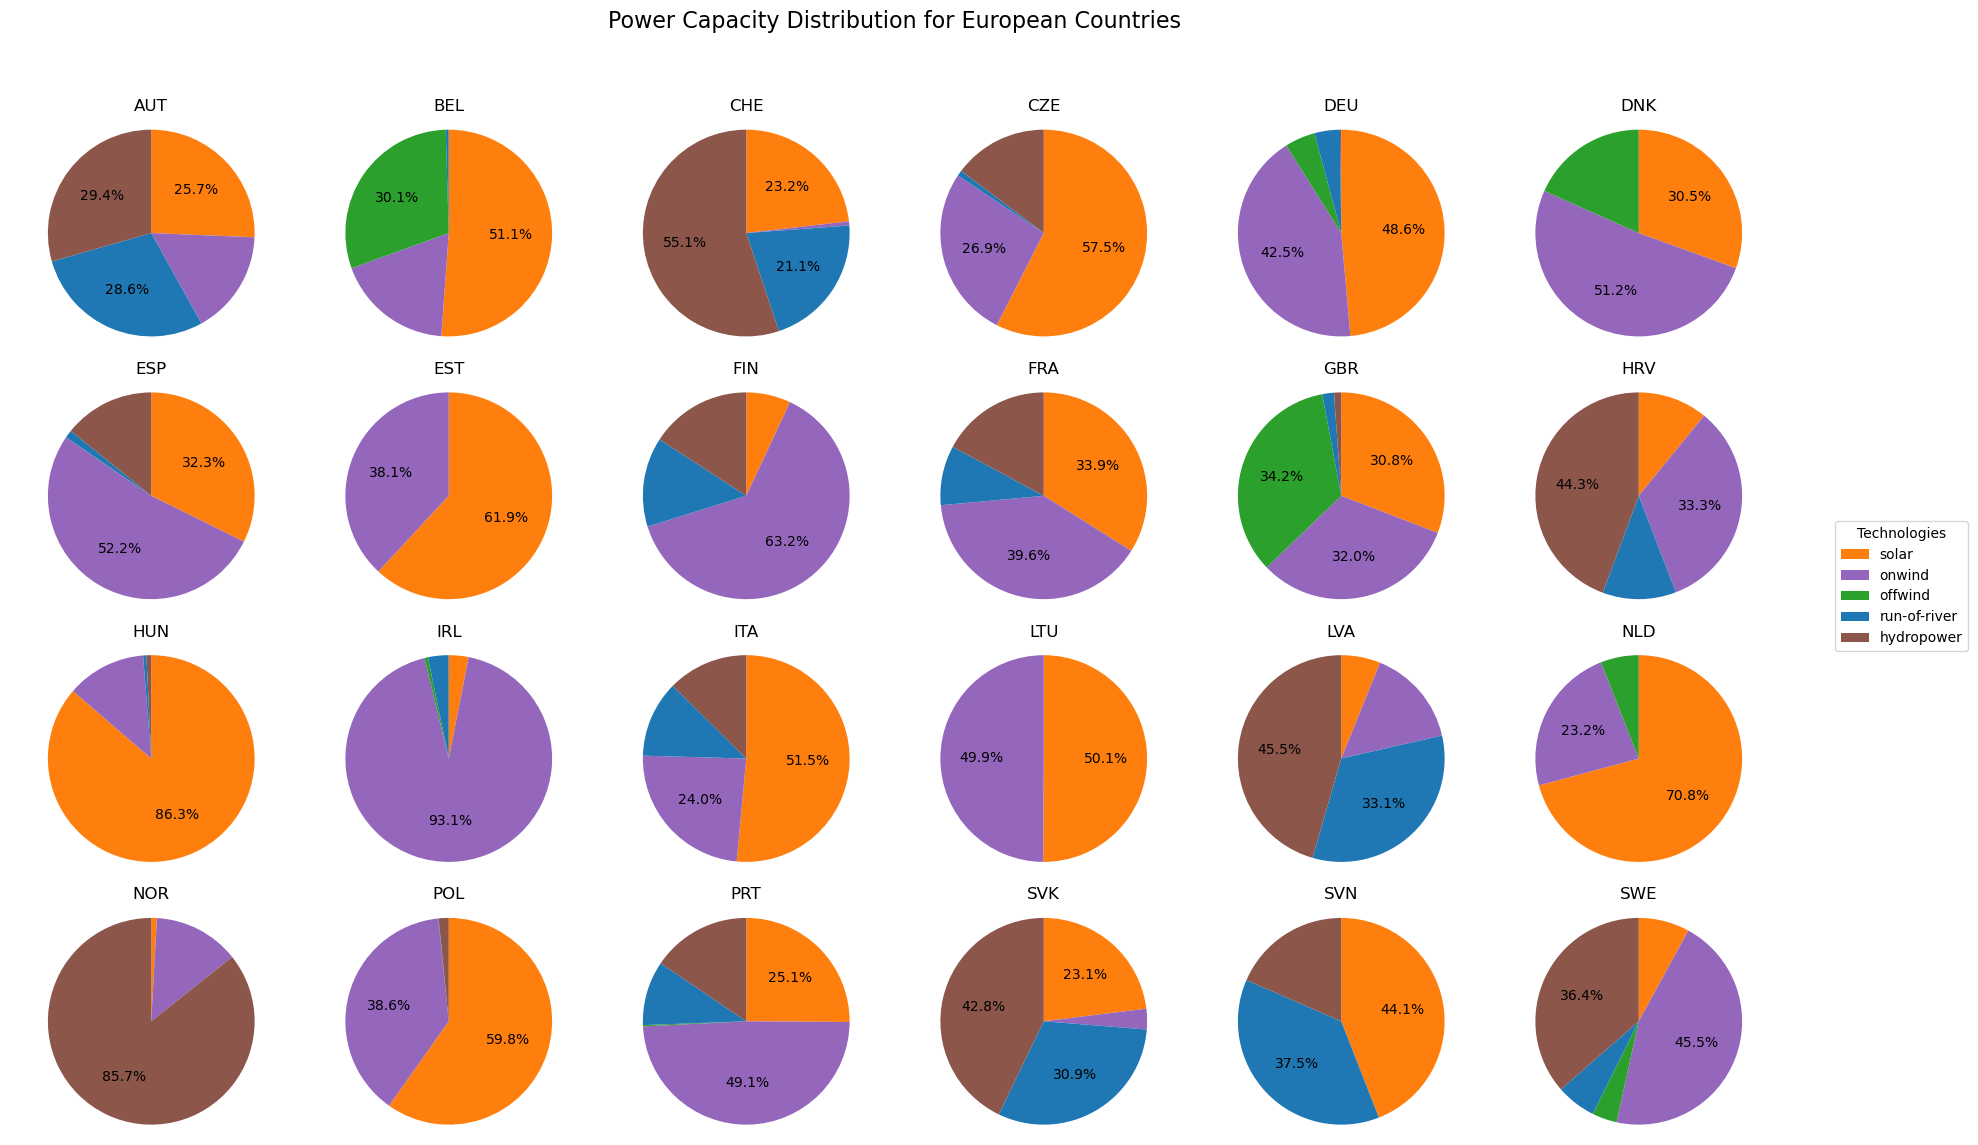

In [7]:
plot_power_capacity_distribution_overview(capacities_2023)

### 2. As fraction of demand

In [8]:
ENERGY_FOLDER = "/net/pc200256//nobackup/users/most/output/LENTIS_2023_PD/agg_production/per_country/"
RUNNAME = "LENTIS_2023_PD"
SEASON_MONTHS = [11, 12, 1, 2, 3]
vars_to_mean = ['pv_util', 'wind_offshore', 'wind_onshore', 'ror', 'residual']

def get_normalized_capacities(country):
    energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
    energy_data = energy_data.where(energy_data.time.dt.month.isin(SEASON_MONTHS))
    mean_dict = {}
    mean_dict['demand'] = energy_data['demand'].mean(dim=['runs', 'time']).values[0]
    for var in vars_to_mean:
        mean_dict[var] = energy_data[var].mean(dim=['runs', 'time']).values[0] / mean_dict['demand']
    return list(mean_dict.values())[1:]

In [27]:
def plot_power_capacity_fraction_of_demand(dataarray: xr.DataArray):
    """
    Plots a 4x6 grid of pie charts showing the power capacity distribution over different technologies
    for 24 specified countries.

    Parameters:
    dataarray (xr.DataArray): The input DataArray with coordinates 'country', 'technology', and 'values'.

    Returns:
    None
    """    
    fig, axs = plt.subplots(4, 6, figsize=(18, 12), dpi=300)
    # fig.suptitle('Electricity mix for European Countries in NDJFM', fontsize=16)
    
    legend_labels = None
    legend_wedges = None

    colors = ['C1', 'C4', 'C2', 'C0', 'grey']

    # def autopct(pct):
    #     return f"{pct:.1f}%" if pct > 15 else ""

    for idx, country_name in enumerate(countries):
        row = idx // 6
        col = idx % 6
        country_id = country_mapping[country_name]
        country_data = dataarray.sel(country=country_id)
        
        technologies = ["Solar PV", "Wind Offshore", "Wind Onshore", "Run-of-river hydropower", "Residual"
        ]
        values = get_normalized_capacities(country_name)

        #HACK: if last value (residual) is negative, set it to 0    
        if values[-1] < 0:
            values[-1] = 0        
        wedges, _  = axs[row, col].pie(values, colors=colors, startangle = 90, counterclock=False)#, autopct=autopct)
        axs[row, col].set_title(country_name, fontsize = 22)
        axs[row, col].axis('equal')
        
        if legend_labels is None:
            legend_labels = technologies
            legend_wedges = wedges
    
    # Create a single legend for the entire figure
    fig.legend(legend_wedges, legend_labels, title="Technologies", loc="center", fontsize = 22, title_fontsize = 22, bbox_to_anchor=(0.5, -0.1))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

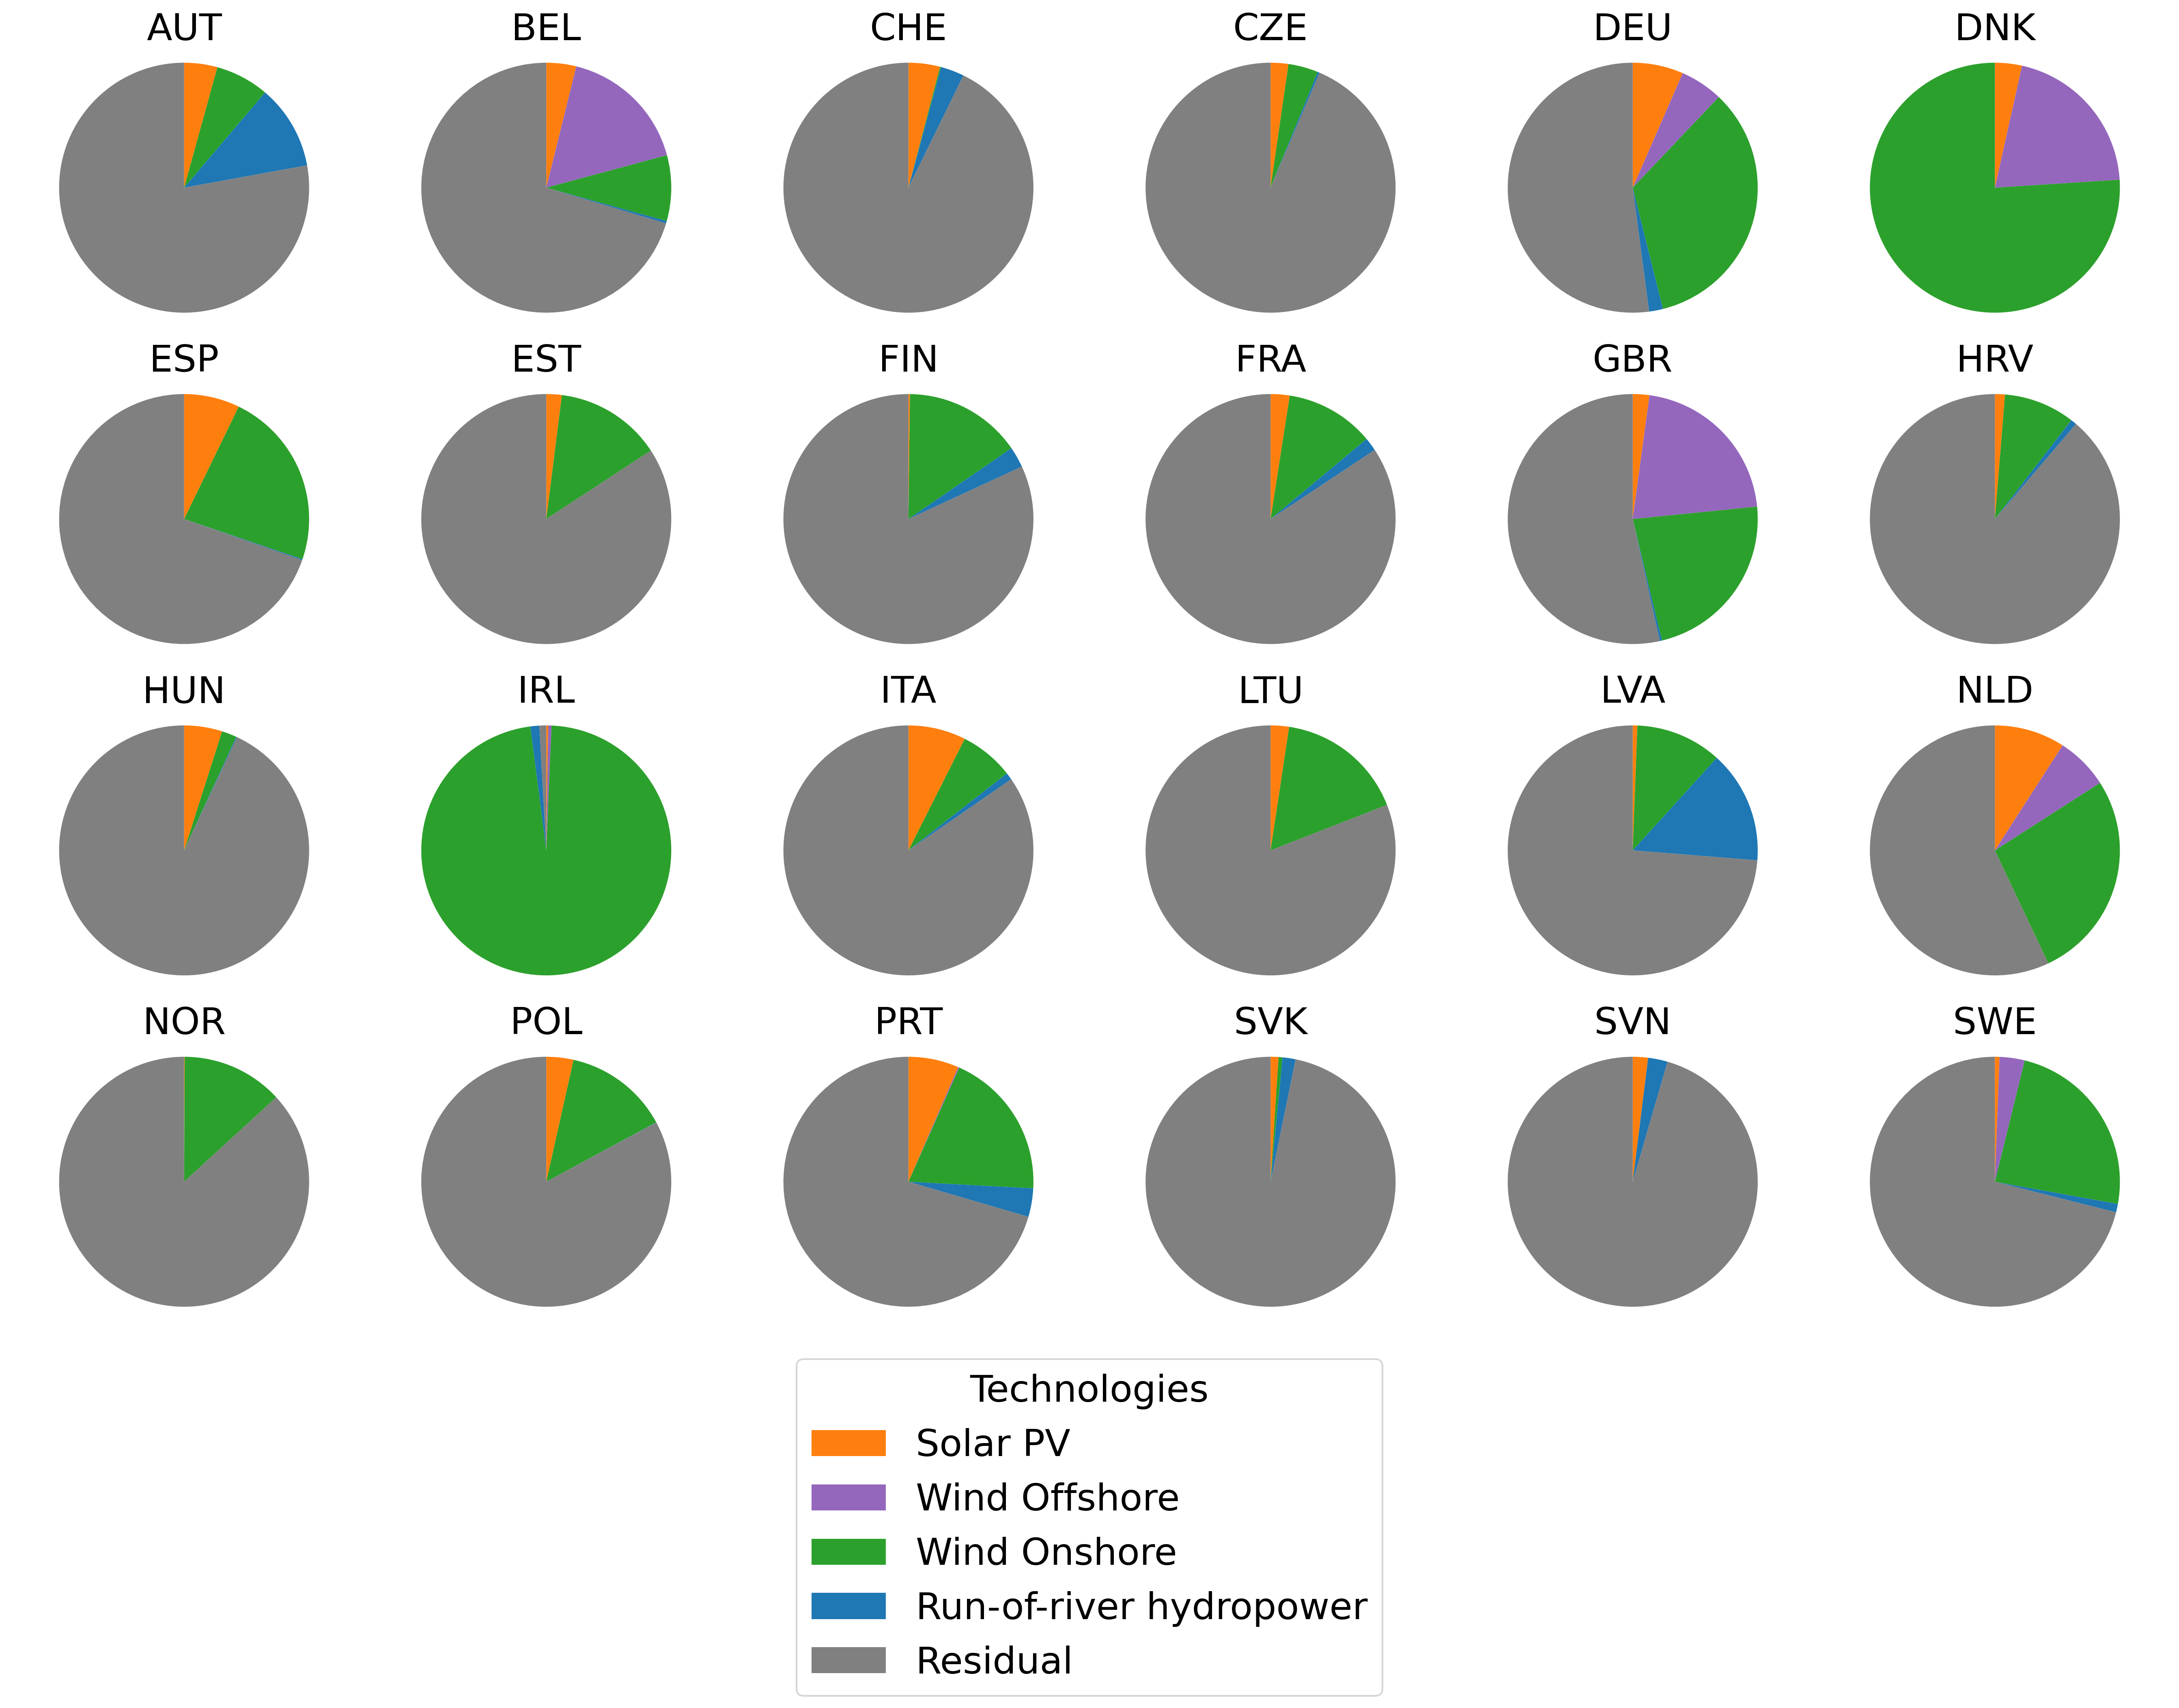

In [28]:
plot_power_capacity_fraction_of_demand(capacities_2023)

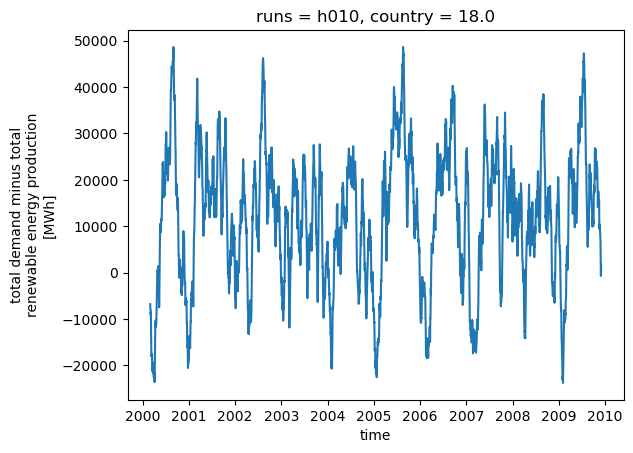

In [94]:
energy_data.residual.isel(runs = 0).rolling(time = 30).mean().plot()

Text(0, 0.5, 'cf wind onshore')

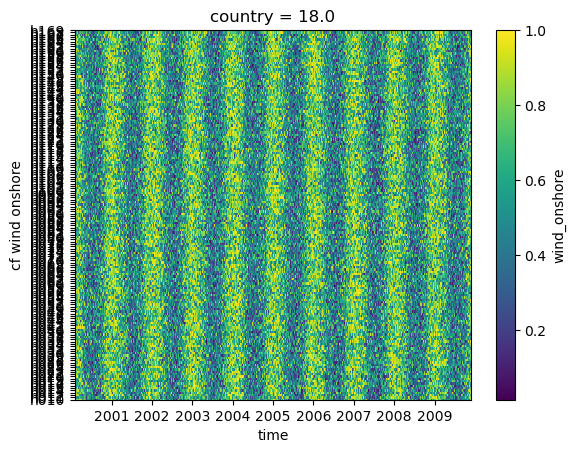

In [90]:
ENERGY_FOLDER = "/net/pc200256//nobackup/users/most/output/LENTIS_2023_PD/agg_production/per_country/"
RUNNAME = "LENTIS_2023_PD"
SEASON_MONTHS = [11, 12, 1, 2, 3]
country = "IRL"
energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
# energy_data = energy_data.where(energy_data.time.dt.month.isin(SEASON_MONTHS))
wind_irl_rolling = energy_data.wind_onshore.rolling(time=7).mean()
wind_irl_cf = wind_irl_rolling / (cap_wind_on_IRL * 24)
plt.figure()
wind_irl_cf.plot()
plt.ylabel('cf wind onshore')

In [63]:
wind_irl_rolling = energy_data.wind_onshore.rolling(time=7).mean()
wind_irl_cf = wind_irl_rolling / (cap_wind_on_IRL * 24)

In [50]:
100 * np.sum(wind_irl_cf > 0.98) / len(wind_irl_cf.time)

<xarray.DataArray 'wind_onshore' ()>
array(0.7518797)
Coordinates:
    runs     <U4 'h010'

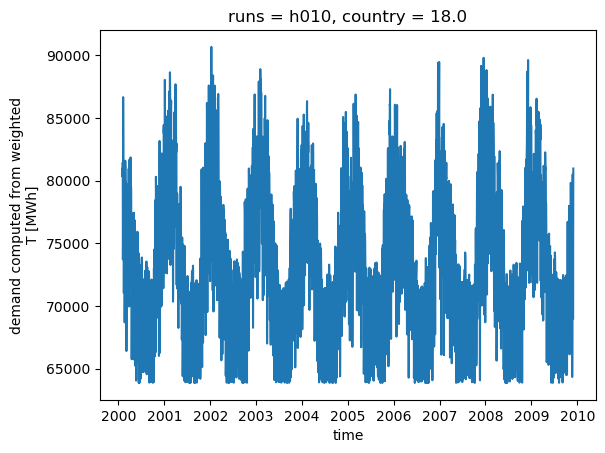

In [13]:
energy_data.demand.isel(runs = 0).plot()

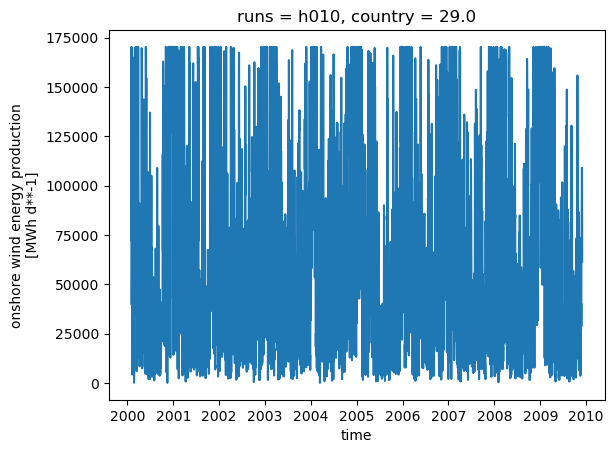

In [14]:
country = "NLD"
energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
energy_data.wind_onshore.isel(runs = 0).plot()

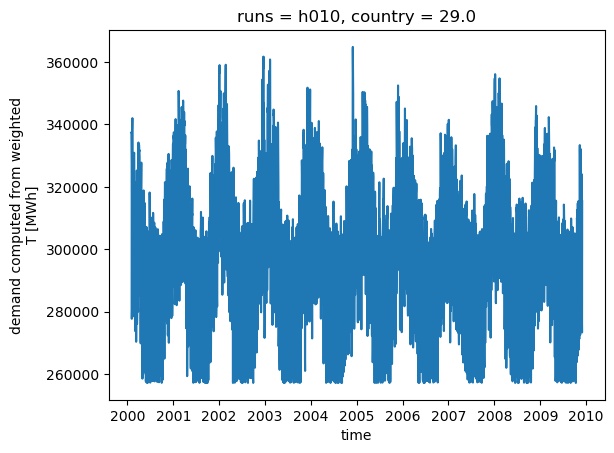

In [15]:
energy_data.demand.isel(runs = 0).plot()

### ERA5 Comparison

Text(0, 0.5, 'cf wind onshore')

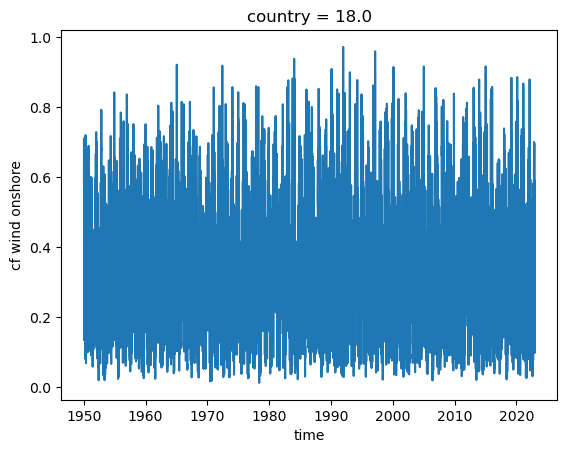

In [32]:
path_era_windsolar = "/net/pc200256/nobackup/users/most/output/ERA5_2023_PD/agg_production/energy_prod_wind_solar/"
path_era_demand = "/net/pc200256/nobackup/users/most/output/ERA5_2023_PD/energy_demand/"
wind_on_irl = xr.open_dataset(path_era_windsolar + "era5_prod_d_1950_2022_agg.nc").wind_onshore.sel(country = 18.0)
demand_irl = xr.open_dataset(path_era_demand + "era5_demand_d_1950_2022.nc").demand.sel(country = 18.0)
wind_irl_rolling_era = wind_on_irl.rolling(time=7).mean()
wind_irl_cf_era = wind_irl_rolling_era / (cap_wind_on_IRL * 24)
plt.figure()
wind_irl_cf_era.plot()
plt.ylabel('cf wind onshore')

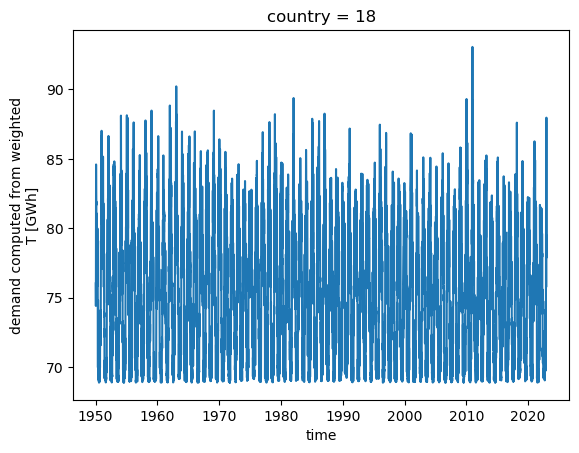

In [27]:
demand_irl.rolling(time=7).mean().plot()

### Compare cf exceedance for multiple countries

In [ ]:
country = "IRL"
energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
wind_irl_rolling = energy_data.wind_onshore.rolling(time=7).mean()
wind_irl_cf = wind_irl_rolling / (cap_wind_on_IRL * 24)

In [84]:
capacities_2023.sel(country = country_mapping['NOR']).values[1]

4937.521891539622

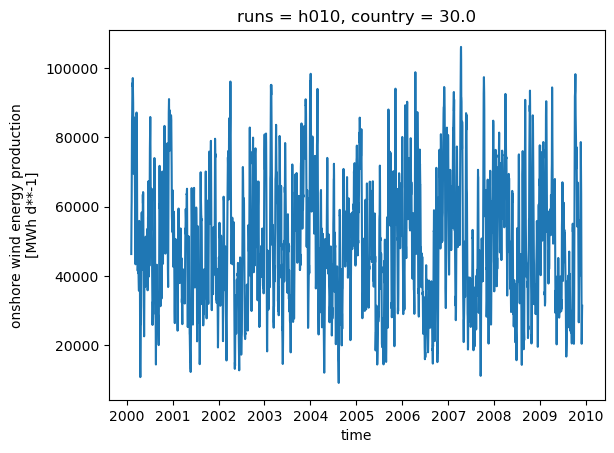

In [86]:
country = "NOR"
energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
wind_LENTIS_rolling = energy_data.wind_onshore.rolling(time=7).mean()
wind_LENTIS_rolling.isel(runs = 0).plot()

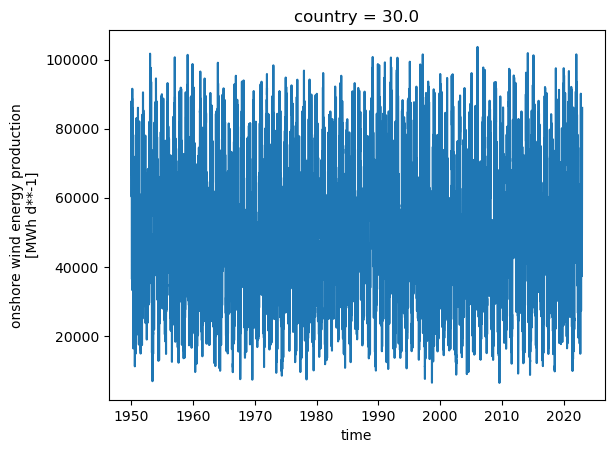

In [88]:
wind_on_irl = xr.open_dataset(path_era_windsolar + "era5_prod_d_1950_2022_agg.nc").wind_onshore.sel(country = country_mapping['NOR'])
wind_era_rolling = wind_on_irl.rolling(time=7).mean()
wind_era_rolling.plot()

In [72]:
def cf_bias(country):
    cap_wind_on_IRL = capacities_2023.sel(country = country_mapping[country]).values[1]

    energy_data = xr.open_dataset(ENERGY_FOLDER + f"{country}_{RUNNAME}.nc")
    wind_LENTIS_rolling = energy_data.wind_onshore.rolling(time=7).mean()
    wind_LENTIS_cf = wind_LENTIS_rolling / (cap_wind_on_IRL * 24)

    wind_on_irl = xr.open_dataset(path_era_windsolar + "era5_prod_d_1950_2022_agg.nc").wind_onshore.sel(country = country_mapping[country])
    wind_era_rolling = wind_on_irl.rolling(time=7).mean()
    wind_cf_era = wind_era_rolling / (cap_wind_on_IRL * 24)

    cf_thres = np.linspace(0.1, 1, 51)
    perc_lentis = []
    perc_era = []

    for cf in cf_thres:
        perc_lentis.append(100 * np.sum(wind_LENTIS_cf > cf) / (160 * len(wind_LENTIS_cf.time)))
        perc_era.append(100 * np.sum(wind_cf_era > cf) / len(wind_cf_era.time))

    plt.figure()
    plt.title(f'Country = {country}')
    plt.plot(cf_thres, perc_lentis, label='LENTIS')
    plt.plot(cf_thres, perc_era, label='ERA5')
    plt.xlabel('cf threshold')
    plt.ylabel('Exceedance (% of time)')
    plt.legend()

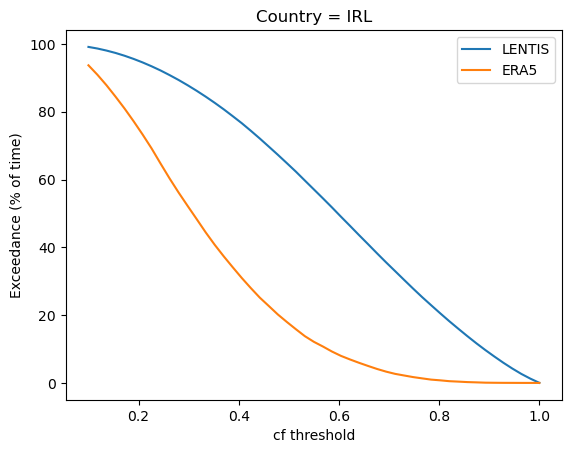

In [73]:
cf_bias('IRL')

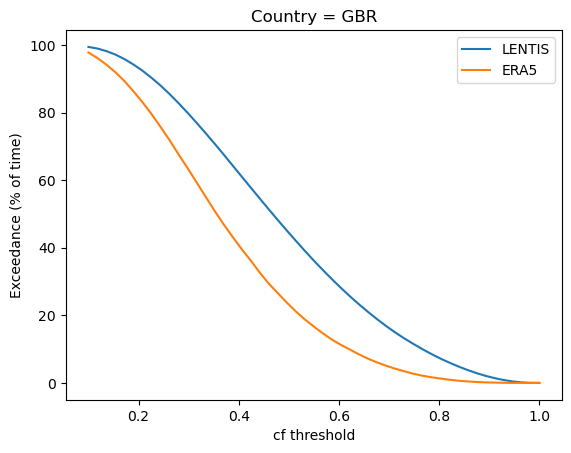

In [75]:
cf_bias('GBR')

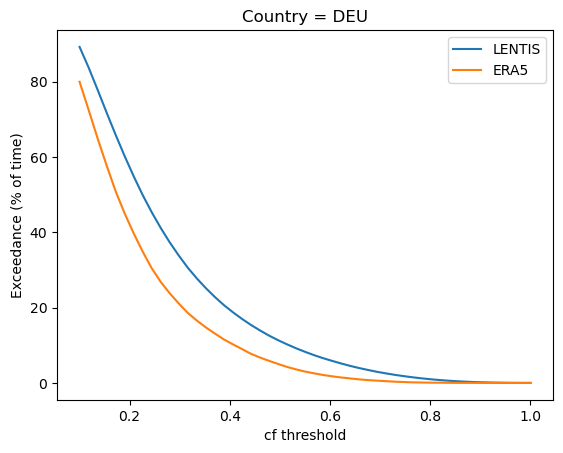

In [76]:
cf_bias('DEU')

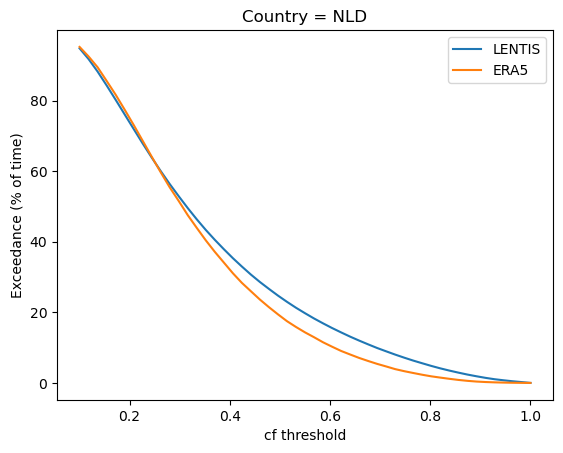

In [74]:
cf_bias('NLD')

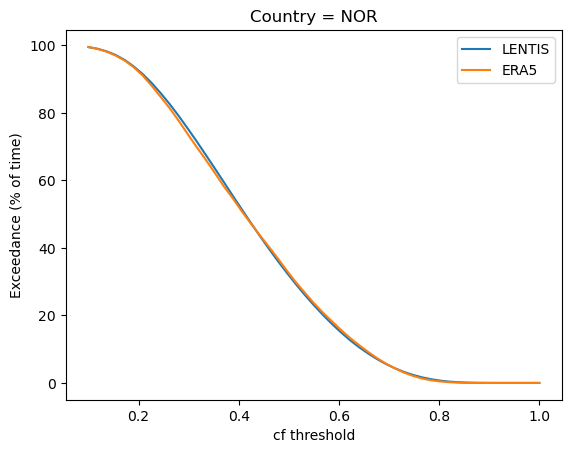

In [77]:
cf_bias('NOR')

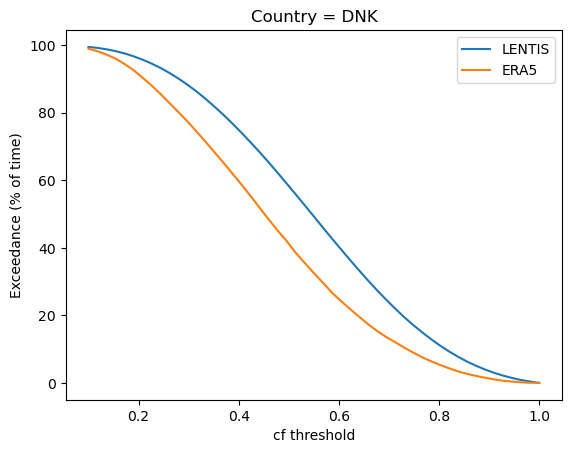

In [78]:
cf_bias('DNK')

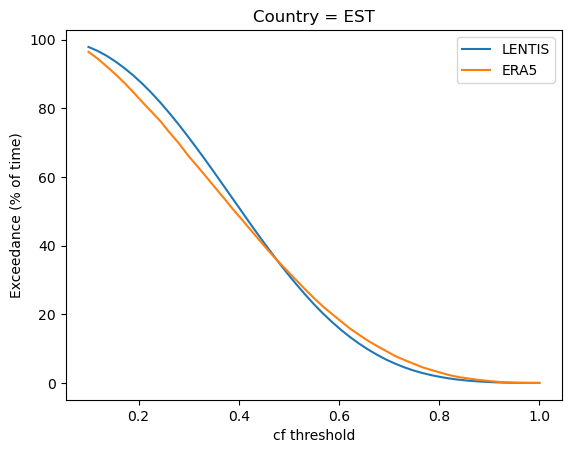

In [79]:
cf_bias('EST')